# Análisis exploratorio no supervisado

En este segundo notebook intentaré encontrar una **posible segmentación de clientes** que permita clasificar a los clientes según sus diferentes compras. 

Espero que esta información sea útil para realizar el próximo punto del proyecto, el modelo supervisado. 

Como hay miles de productos en el conjunto de datos, me basaré de los pasillos y departamentos, que representan categorías de productos. Incluso con las funciones de los pasillos será demasiado, así que usaré el **Análisis de componentes principales para encontrar nuevas dimensiones** a lo largo de las cuales el agrupamiento pueda ser más fácil. 

Más adelante trataré de encontrar posibles diferencias entre los grupos identificados.

## Carga de librerías y ficheros

In [4]:
import numpy as np 
import pandas as pd 
# Para clusterizar los datos
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
#Para realizar graficas de los datos
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

In [5]:
# Tablas de ordenes
orders = pd.read_csv('../../DATOS/orders.csv')
prior = pd.read_csv('../../DATOS/order_products__prior.csv')
##Para poder trabajar en mi ordenador mas agilmente he decidido reducir el número de muestras usadas 
prior = prior[0:500000]
#Dado que se trata de un analisis exploratorio solo necesitare los datos de entrada y no es necesario cargar los de train
#train = pd.read_csv('../../DATOS/order_products__train.csv')
# Tablas de productos
products = pd.read_csv('../../DATOS/products.csv')
aisles = pd.read_csv('../../DATOS/aisles.csv')
departments = pd.read_csv('../../DATOS/departments.csv')

#### Explicacion de datos que utilizaré para la clusterización:

* los **usuarios** son identificados por **user_id** en el archivo csv de pedidos. Cada fila de las órdenes representa una orden realizada por un usuario. Los **pedidos se identifican por order_id**.

* **cada pedido consta de un conjunto de productos**, cada uno caracterizado por una variable **add_to_cart_order** que representa la secuencia en la que se han agregado al carrito en ese orden;

* **para cada usuario podemos tener** n-1 pedidos anteriores y 1 pedido de entrenamiento O n-1 pedidos anteriores y 1 pedido de prueba en el que tenemos que indicar qué productos se han reordenado.

### Generación de tabla única

Dado que para este proyecto partimos de tablas auxiliares voy a unir distintas tablas en una con la que poder trabajar la cual llamare MT (Multi Tabla) y ordenaré por usuario.

Añado las tablas que tienen los datos informativos (PRODUCT, AISLES) para traducir el ID de producto y el de tipo
Despues he procedido a unirlas en una unica tabla

PRIOR + ORDER + PRODUCT + AISLES = MT


In [6]:
order_prior = pd.merge(prior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior_mt = pd.merge(order_prior,products, on = ['product_id','product_id'])
#order_prior_mt = pd.merge(order_prior_mt,orders,on=['order_id','order_id'])
mt_1 = pd.merge(order_prior_mt,aisles,on=['aisle_id','aisle_id'])
mt = pd.merge(mt_1,departments,on=['department_id','department_id'])
#order_prior_mt.head(5)
mt.head(5)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,23391,13198,1,1,7,prior,17,0,10,28.0,85% Lean Ground Beef,122,12,meat counter,meat seafood
1,50222,13198,5,1,2165,prior,2,6,10,30.0,85% Lean Ground Beef,122,12,meat counter,meat seafood
2,5932,13198,6,1,5030,prior,10,2,11,6.0,85% Lean Ground Beef,122,12,meat counter,meat seafood
3,38991,13198,7,1,6351,prior,3,4,16,30.0,85% Lean Ground Beef,122,12,meat counter,meat seafood
4,4339,13198,26,0,6409,prior,23,0,7,8.0,85% Lean Ground Beef,122,12,meat counter,meat seafood


### Análisis previo a la clusterización
Ahora voy a comprobar cuales son los **productos más demandados** y la cantidad de estos.


In [10]:
len(mt['product_name'].unique())
mt['product_name'].value_counts()[0:10]

Banana                    7365
Bag of Organic Bananas    5920
Organic Strawberries      4023
Organic Baby Spinach      3797
Organic Hass Avocado      3317
Organic Avocado           2712
Large Lemon               2355
Strawberries              2225
Organic Raspberries       2177
Limes                     2116
Name: product_name, dtype: int64

Las frutas frescas y las verduras frescas son los productos más vendidos.

Buscamos **cuantos tipos de productos diferentes hay por pasillo y departamento**

In [11]:
print 'Pasillos distintos', len(mt['aisle'].unique())
print 'Departamentos distintos', len(mt['department'].unique())

Pasillos distintos 134
Departamentos distintos 21


In [12]:
print 'PASILLOS:\r\n\r\n', mt['aisle'].value_counts()[0:10], '\r\n\r\n'
print 'DEPARTAMENTOS:\r\n\r\n',mt['department'].value_counts()[0:10]

PASILLOS:

fresh fruits                     56326
fresh vegetables                 52073
packaged vegetables fruits       27347
yogurt                           22485
packaged cheese                  14960
milk                             13715
water seltzer sparkling water    12778
chips pretzels                   10982
soy lactosefree                  10056
bread                             9240
Name: aisle, dtype: int64 


DEPARTAMENTOS:

produce            145463
dairy eggs          83779
snacks              44513
beverages           41613
frozen              34773
pantry              28652
bakery              18205
canned goods        16370
deli                16220
dry goods pasta     13171
Name: department, dtype: int64


Quiero encontrar un posible **clúster entre los diferentes clientes** y sustituir el ID de usuario único con el clúster al que se supone que pertenecen. Espero que esto **aumente el rendimiento del próximo modelo de predicción**.

Lo primero que debe hacer es crear un **DataFrame**, para ello usaré pandas con todas las compras realizadas por cada usuario organizadas por pasillo.

In [15]:
# Por Pasillo
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
print 'Rango del dataframe', cust_prod.shape
cust_prod.head(5)


Rango del dataframe (39834, 134)


aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,4
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Ahora ejecutaré un **Análisis de componentes principales** en el Data Frame obtenido. Esto reducirá el número de funciones del número de pasillos a 6, el número de componentes principales que he elegido.

Para ello usaré **PCA: Principal Component Análisis**

In [16]:
# Para reducir el número de funciones voy a emplear decomposition de la librería scikit-learn (sklearn)
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-0.434904,0.964055,-1.085494,-0.804552,-0.461699,-1.123651
1,-2.163437,-0.472227,-0.130003,0.238158,0.045775,-0.175864
2,-1.316257,1.287541,3.167225,0.659952,-0.599893,-1.081665
3,-1.588246,1.262179,3.217635,1.250336,-0.408611,-0.299575
4,-2.262804,-0.397136,-0.112548,0.289925,-0.004481,-0.063747


He ilustrado varios pares de componentes buscando el adecuado para un agrupamiento de KMeans. **He elegido el par (PC4, PC2)**. Dado que cada componente es la proyección de todos los puntos del conjunto de los datos, creo que cada componente es representativo del conjunto de datos.

### Clusterización de los Datos 

(39834, 2)
          4         2
0 -0.461699 -1.085494
1  0.045775 -0.130003
2 -0.599893  3.167225
3 -0.408611  3.217635
4 -0.004481 -0.112548


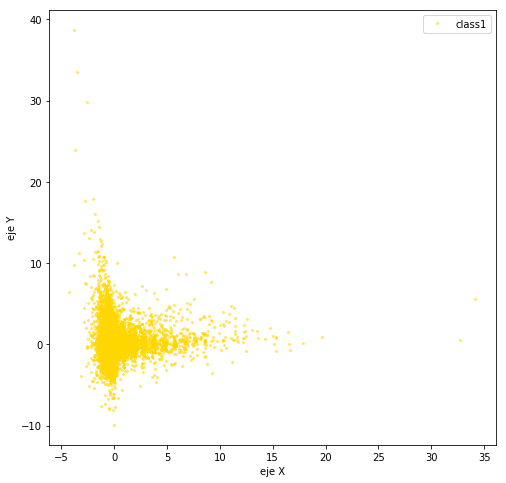

In [17]:
tocluster = pd.DataFrame(ps[[4,2]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[2], 'o', markersize=2, color='gold', alpha=0.5, label='class1')

plt.xlabel('eje X')
plt.ylabel('eje Y')
plt.legend()
plt.show()

In [26]:
#Ahora calcularé el centro de cada uno de los 4 grupos en los uqe voy a dividir los datos
clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print 'Centros de los 4 grupos: \n', (centers), '\n'
print 'Predicciones: \n',(c_preds[0:100])

Centros de los 4 grupos: 
[[-0.03475716  0.14502587]
 [-0.35227731  2.95874639]
 [ 6.20773515  0.70266183]
 [-0.12118023 -1.14341434]] 

Predicciones: 
[3 0 1 1 0 0 0 3 0 0 0 3 0 0 1 0 0 1 3 0 0 3 0 0 2 0 3 3 3 0 0 0 0 0 3 3 3
 1 0 0 0 0 0 0 0 0 0 0 3 0 3 3 0 0 3 0 0 0 1 3 0 1 3 0 0 0 0 1 0 1 3 3 0 0
 0 3 0 0 2 1 3 0 0 3 0 0 0 3 0 0 0 0 1 3 0 0 3 0 0 0]


Así es como aparecen los clusters creados.

['green', 'yellow', 'blue', 'blue', 'yellow', 'yellow', 'yellow', 'green', 'yellow', 'yellow']


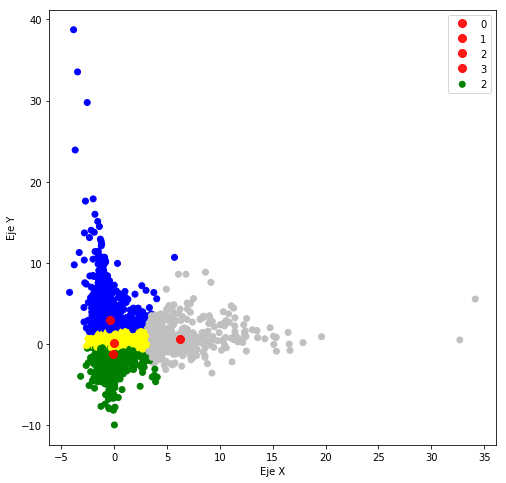

In [27]:
fig = plt.figure(figsize=(8,8))
colors = ['yellow','blue','silver','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[2],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.legend()
plt.show()

He encontrado un posible agrupamiento en clúster para nuestros clientes. Comprobaré si también puedo encontrar algún **patrón** interesante debajo de él.


In [32]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds
clust_prod.head(5)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
13,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,4,1
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,4,1
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


(39834, 135)


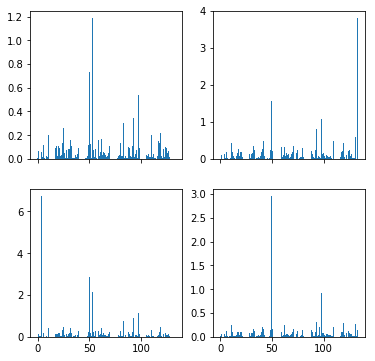

In [33]:
print (clust_prod.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(6,6))

c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.show()


Veamos cuáles son los 10 productos principales comprados por las personas de cada grupo. Primero vamos a confiar en los datos absolutos y luego en un porcentaje entre los 8 productos principales de cada grupo.

In [34]:
print 'Grupo 0: \r\n'
c0.sort_values(ascending=False)[0:10]

Grupo 0: 



aisle
fresh vegetables                 1.191141
fresh fruits                     0.735781
packaged vegetables fruits       0.540676
yogurt                           0.378858
packaged cheese                  0.344301
water seltzer sparkling water    0.310667
milk                             0.301047
chips pretzels                   0.259563
soy lactosefree                  0.215154
bread                            0.204957
dtype: float64

In [35]:
print 'Grupo 1: \r\n'
c1.sort_values(ascending=False)[0:10]

Grupo 1: 



aisle
yogurt                           3.813603
fresh vegetables                 2.187132
fresh fruits                     1.563603
packaged vegetables fruits       1.066912
packaged cheese                  0.808456
milk                             0.682353
water seltzer sparkling water    0.581250
chips pretzels                   0.535294
energy granola bars              0.496691
refrigerated                     0.481618
dtype: float64

In [36]:
print 'Grupo 2: \r\n'
c2.sort_values(ascending=False)[0:10]

Grupo 2: 



aisle
baby food formula             6.755424
fresh fruits                  2.850099
fresh vegetables              2.157791
yogurt                        1.392505
packaged vegetables fruits    1.159763
packaged cheese               0.881657
milk                          0.747535
soy lactosefree               0.477318
chips pretzels                0.457594
bread                         0.437870
dtype: float64

In [37]:
print 'Grupo 3: \r\n'
c3.sort_values(ascending=False)[0:10]

Grupo 3: 



aisle
fresh fruits                     2.966576
fresh vegetables                 1.325393
packaged vegetables fruits       0.923359
milk                             0.344318
packaged cheese                  0.317013
soy lactosefree                  0.287449
water seltzer sparkling water    0.274456
frozen produce                   0.245645
chips pretzels                   0.239996
bread                            0.238396
dtype: float64

Un primer análisis de los grupos confirma la hipótesis inicial de que:

* fresh fruits                     
* fresh vegetables                 
* packaged vegetables fruits       
* yogurt                           
* packaged cheese                   
* milk                              
* water seltzer sparkling water     
* bread                    

Son productos que genéricamente son **comprados por la mayoría de los clientes**.

Lo que se puede ver aquí es que **los grupos difieren en cantidades y proporciones**, con respecto a estos productos, o si un grupo se caracteriza por algunos **productos que no están incluidos en esta lista**. 

Por ejemplo, ya podemos ver que el grupo 2 se caracteriza por "Fórmula de alimentos para bebés" 'producto que es una diferencia significativa con respecto a los otros grupos.

In [38]:
from IPython.display import display, HTML
cluster_means = [[c0['fresh fruits'],c0['fresh vegetables'],c0['packaged vegetables fruits'], c0['yogurt'], c0['packaged cheese'], c0['milk'],c0['water seltzer sparkling water'],c0['chips pretzels']],
                 [c1['fresh fruits'],c1['fresh vegetables'],c1['packaged vegetables fruits'], c1['yogurt'], c1['packaged cheese'], c1['milk'],c1['water seltzer sparkling water'],c1['chips pretzels']],
                 [c2['fresh fruits'],c2['fresh vegetables'],c2['packaged vegetables fruits'], c2['yogurt'], c2['packaged cheese'], c2['milk'],c2['water seltzer sparkling water'],c2['chips pretzels']],
                 [c3['fresh fruits'],c3['fresh vegetables'],c3['packaged vegetables fruits'], c3['yogurt'], c3['packaged cheese'], c3['milk'],c3['water seltzer sparkling water'],c3['chips pretzels']]]
cluster_means = pd.DataFrame(cluster_means, columns = ['fresh fruits','fresh vegetables','packaged vegetables fruits','yogurt','packaged cheese','milk','water seltzer sparkling water','chips pretzels'])
HTML(cluster_means.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,0.735781,1.191141,0.540676,0.378858,0.344301,0.301047,0.310667,0.259563
1,1.563603,2.187132,1.066912,3.813603,0.808456,0.682353,0.581250,0.535294
2,2.850099,2.157791,1.159763,1.392505,0.881657,0.747535,0.412229,0.457594
3,2.966576,1.325393,0.923359,0.146973,0.317013,0.344318,0.274456,0.239996


In [39]:
cluster_perc = cluster_means.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())

,fresh fruits,fresh vegetables,packaged vegetables fruits,yogurt,packaged cheese,milk,water seltzer sparkling water,chips pretzels
0,18.113608,29.323771,13.310470,9.326803,8.476070,7.411232,7.648073,6.389973
1,13.912787,19.460892,9.493278,33.933069,7.193562,6.071510,5.171906,4.762995
2,28.333333,21.450980,11.529412,13.843137,8.764706,7.431373,4.098039,4.549020
3,45.373771,20.271885,14.122780,2.247951,4.848720,5.266341,4.197808,3.670742


Esta tabla muestra **el porcentaje de estos productos con respecto a los otros 8 principales de cada grupo**. Es fácil algunas diferencias interesantes entre los grupos.

Parece que la **gente del grupo 3 compra más verduras frescas que los otros grupos**. Como lo muestran los datos absolutos.

Las personas **del grupo 1 compran más Yogurt** que las personas de los otros grupos.

Las personas **del grupo 2** compran una gran cantidad de "**Fórmula de alimentos para bebés**" que ni siquiera figuran en los 8 mejores productos, pero caracterizan principalmente este grupo. En teoría con esta observación, **comprarán más leche que los demás**.

Otra información interesante puede ser ver los productos más comprados **del 8 al 15 de cada grupo**, que no incluirán los productos genéricos (es decir, verduras, frutas, agua, etc.) comprados por nadie.

In [40]:
c0.sort_values(ascending=False)[8:15]

aisle
soy lactosefree    0.215154
bread              0.204957
refrigerated       0.204187
ice cream ice      0.193874
frozen produce     0.171823
eggs               0.160356
crackers           0.159124
dtype: float64

In [43]:
c1.sort_values(ascending=False)[8:15]

aisle
energy granola bars    0.496691
refrigerated           0.481618
soy lactosefree        0.430147
bread                  0.426471
crackers               0.344853
ice cream ice          0.344118
cereal                 0.324265
dtype: float64

In [44]:
c2.sort_values(ascending=False)[8:15]

aisle
chips pretzels                   0.457594
bread                            0.437870
frozen produce                   0.420118
water seltzer sparkling water    0.412229
crackers                         0.402367
refrigerated                     0.341223
cereal                           0.321499
dtype: float64

In [45]:
c3.sort_values(ascending=False)[8:15]

aisle
chips pretzels         0.239996
bread                  0.238396
refrigerated           0.210338
packaged produce       0.199040
eggs                   0.198945
crackers               0.163638
energy granola bars    0.162414
dtype: float64

Como se puede observar, los productos de los grupos comienzan a **diferir significativamente**. Espero que esta información sea útil en el proximo punto del proyecto de Fin de Master.

## Ahora analisis con los departamentos
Ademas de clusterizar usuarios basandome en los pasillos, voy a realizar otra clusterización por departamento para ver si me puede aportar información útil para el análisis.

In [46]:
# Por Departamento
cust_prod_dep = pd.crosstab(mt['user_id'], mt['department'])
print 'Rango del dataframe', cust_prod_dep.shape
cust_prod_dep.head(5)

# Para reducir el número de funciones voy a emplear decomposition de la librería scikit-learn (sklearn)
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod_dep)
pca_samples = pca.transform(cust_prod_dep)
# Tranformo la tabla a DataFrame
ps = pd.DataFrame(pca_samples)
ps.head()

Rango del dataframe (39834, 21)


,0,1,2,3,4,5
0,0.148710,-0.256128,0.316619,1.189911,-0.750626,-0.642727
1,-3.918901,-0.225941,-0.922711,-0.325929,-0.031086,1.088999
2,-2.107704,1.606258,-2.239194,0.836007,-0.629441,-0.356145
3,-2.360409,4.717012,1.424465,4.830325,-0.559423,-0.898022
4,-4.283036,-0.251262,0.992932,-1.086045,-1.090002,-0.222556


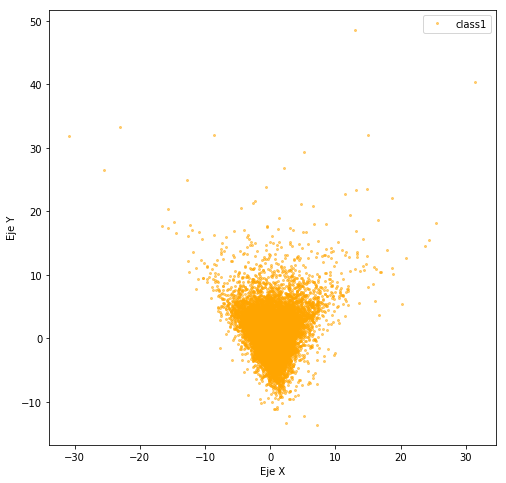

In [48]:
tocluster = pd.DataFrame(ps[[2,1]])
#print (tocluster.shape)
#print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[2], tocluster[1], 'o', markersize=2, color='orange', alpha=0.5, label='class1')

plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.legend()
plt.show()

In [49]:
clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

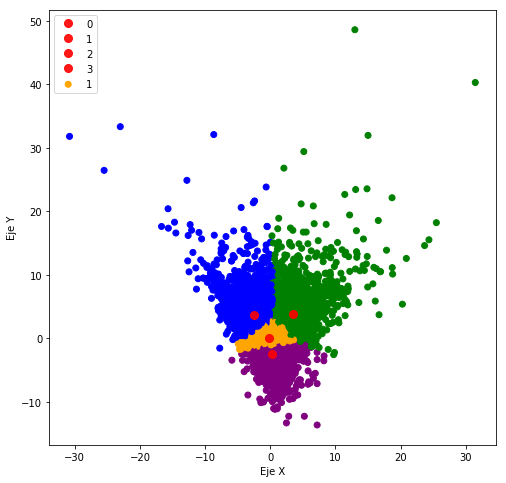

In [51]:
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
#print (colored[0:10])
plt.scatter(tocluster[2],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.legend()
plt.show()

(39834, 22)


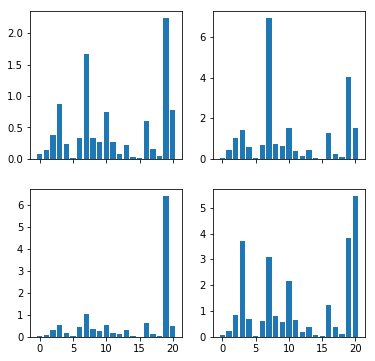

In [52]:
clust_prod_dep = cust_prod_dep.copy()
clust_prod_dep['cluster'] = c_preds

#clust_prod_dep.head(5)

print (clust_prod_dep.shape)
f,arr = plt.subplots(2,2,sharex=True,figsize=(6,6))

c1_count = len(clust_prod_dep[clust_prod_dep['cluster']==0])

c0 = clust_prod_dep[clust_prod_dep['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod_dep.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod_dep[clust_prod_dep['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod_dep.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod_dep[clust_prod_dep['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod_dep.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod_dep[clust_prod_dep['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod_dep.drop('cluster',axis=1).columns)),c3)
plt.show()

In [54]:
print 'Grupo 0: \r\n'
print c0.sort_values(ascending=False)[0:7]

print 'Grupo 1: \r\n'
print c1.sort_values(ascending=False)[0:7]

print 'Grupo 2: \r\n'
print c2.sort_values(ascending=False)[0:7]

print 'Grupo 3: \r\n'
print c3.sort_values(ascending=False)[0:7]


Grupo 0: 

department
produce       2.245625
dairy eggs    1.675157
beverages     0.873403
snacks        0.777397
frozen        0.747740
pantry        0.604266
bakery        0.376898
dtype: float64
Grupo 1: 

department
dairy eggs    6.956278
produce       4.042922
frozen        1.531058
snacks        1.523594
beverages     1.420688
pantry        1.260197
bakery        1.020794
dtype: float64
Grupo 2: 

department
produce         6.413255
dairy eggs      1.025425
pantry          0.625537
frozen          0.550383
beverages       0.543279
snacks          0.496168
canned goods    0.441297
dtype: float64
Grupo 3: 

department
snacks        5.475410
produce       3.845287
beverages     3.708333
dairy eggs    3.106899
frozen        2.168716
pantry        1.251025
bakery        0.857582
dtype: float64


In [56]:
#from IPython.display import display, HTML
cluster_means_dep = [[c0['produce'],c0['dairy eggs'],c0['beverages'],c0['snacks'], c0['frozen'], c0['pantry'],c0['bakery']],
                 [c1['dairy eggs'],c1['produce'],c1['frozen'], c1['snacks'], c1['beverages'], c1['pantry'],c1['bakery']],
                 [c2['produce'],c2['dairy eggs'],c2['pantry'], c2['frozen'], c2['beverages'], c2['snacks'],c2['canned goods']],
                 [c3['snacks'],c3['produce'],c3['beverages'], c3['dairy eggs'], c3['frozen'], c3['pantry'],c3['bakery']]]
cluster_means_dep = pd.DataFrame(cluster_means_dep, columns = ['dairy eggs','beverages','produce','snacks','frozen','pantry','bakery'])
HTML(cluster_means_dep.to_html())

,dairy eggs,beverages,produce,snacks,frozen,pantry,bakery
0,2.245625,1.675157,0.873403,0.777397,0.747740,0.604266,0.376898
1,6.956278,4.042922,1.531058,1.523594,1.420688,1.260197,1.020794
2,6.413255,1.025425,0.625537,0.550383,0.543279,0.496168,0.441297
3,5.475410,3.845287,3.708333,3.106899,2.168716,1.251025,0.857582


In [57]:
cluster_perc = cluster_means_dep.iloc[:, :].apply(lambda x: (x / x.sum())*100,axis=1)
HTML(cluster_perc.to_html())

,dairy eggs,beverages,produce,snacks,frozen,pantry,bakery
0,30.759941,22.945830,11.963622,10.648563,10.242334,8.277065,5.162644
1,39.178090,22.769928,8.622994,8.580952,8.001381,7.097491,5.749163
2,63.526852,10.157407,6.196296,5.451852,5.381481,4.914815,4.371296
3,26.822821,18.837209,18.166304,15.220010,10.624059,6.128493,4.201104


## Conclusiones:

El **grupo 0** es el que más bebida y productos de despensa compra, posiblemente sus tiempos de reorden sean superiores
El **Grupo 2** es el que mas huevos compra
El **grupo 3** compra mas snacks y productos congelados por lo que se podría decir que tienen habitos de compra menos saludables y por tanto posiblemente comprarán menos frutas y verduras.

Una vez visto el análisis no supervisado de productos por pasillo y departamento, se puede ver que **no se aprecian diferencias entre los grupos creados y no se pueden ver grupos claramente diferenciados**.

En la **elaboración del modelo** que haré en el siguiente notebook utilizaré estas conclusiones para tratar de orientar el modelo predictivo.